In [255]:
# Load in PyTorch's pretrained network
import torchvision.models as models
import torch
import numpy as np
from torch.autograd import Variable
import torchvision.transforms as transforms
import torch.nn.functional as func
import pandas as pd
from torch.utils.data.dataset import Dataset
from PIL import Image
from torch.utils.data.sampler import SubsetRandomSampler
from random import shuffle
import matplotlib.pyplot as plt
import os

In [14]:
class UtilFuncs():
    def plot_losses(self):
        return 0
    def plot_images(self):
        return 0

In [326]:
# Add separate transformations for testing and training 
# Augmentatiosn for data?
class CHXData(Dataset):
    def __init__(self, img_dir, path_to_labels):
        self.img_dir = img_dir
        self.data_df = pd.read_csv(path_to_labels)
        self.img_names = self.data_df['Image Index']
        self.labels = np.asarray(self.data_df.loc[:, self.data_df.columns != 'Image Index'])
        self.transform = transforms.Compose([
            transforms.Resize(512),
            transforms.ToTensor()
        ])
        
    # Return size of the dataset
    def __len__(self):
        return len(self.data_df)
    
    # Returns image and a label, given a sample index
    # Both return values are tensors
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        # Should be split up when actual transforms for the images is added
        image = self.transform(Image.open(img_path).convert('RGB'))
        label = self.labels[idx]
        return (image, label)
    
    def split_data(self, split):
        dataset_len = self.__len__()
        indices = list(range(dataset_len))
        set_one_len = int(np.floor(0.1 * dataset_len))
        set_one_idx = np.random.choice(indices, size=set_one_len, replace=False)
        set_two_idx = [idx for idx in indices if idx not in set_one_idx]
        return (set_one_idx, set_two_idx)

In [377]:
class CHXModel():
    def __init__(self):
        self.model = None
        self.losses = None
        self.optimizer = None
    
    # Freeze or un-freeze model layers as required
    def update_grad(self, grad_val):
        for param in self.model.parameters():
            param.requires_grad = grad_val
            
    # Initial model setup
    def set_up_model(self, n_classes, lr):
        self.model = models.resnet34(pretrained=True, progress=True)
        # Freeze all layers
        self.update_grad(False)
        # Resnet has one fully connected layer, which outputs dimensions of n_classes
        num_ftrs = self.model.fc.in_features
        self.model.fc = torch.nn.Linear(num_ftrs, n_classes)
        # Use a binary cross-entropy loss function; Applies sigmoid internally (generating probabilities)
        # On the probabilities, cross-entropy loss is computed
        # Because we are doing multilabel, this is better as the value outtputted (unlike softmax)
        # is independent of the other values (while in softmax, probabilities must add up to one)
        self.losses =  torch.nn.BCEWithLogitsLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        
    # Save checkpoints as it happens    
    # Also save model with the highest validation accuracy
    def train(self, epochs, trainloader):
        for e in range(epochs):
            # Get loss per epoch
            running_loss = 0
            for i, (X, y) in enumerate(trainloader):
                input_img = Variable(X)
                labels = Variable(y)
                self.optimizer.zero_grad()
                output = self.model(input_img)
                loss = self.losses(output, labels)
                loss.backward()
                self.optimizer.step()
                running_loss = running_loss + loss.item()
            # Find the loss for the current epoch
            loss = running_loss/len(trainloader)
            print(f"Epoch {e + 1} - Loss: {loss}")
        
    # Use the best model for evaluation (based on highest evaluation accuracy)
    def evaluate(self):s
        return 0

In [378]:
n_classes = 15
learning_rate = 1e-4
chx_model = CHXModel()
chx_model.set_up_model(n_classes, learning_rate)

In [379]:
path_to_train_data = './data/Train/'
path_to_test_data = './data/Test/'
path_to_test_labels = './data/Labels/Test_Labels.csv'
path_to_train_labels = './data/Labels/Train_Labels.csv'

In [380]:
# Create dataset and data loader
test_dataset = CHXData(path_to_test_data, path_to_test_labels)
train_dataset = CHXData(path_to_train_data, path_to_train_labels)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False)

In [381]:
val_idx, train_idx = train_dataset.split_data(split=0.1)
val_idx = shuffle(val_idx)
train_idx  = shuffle(train_idx)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, sampler=SubsetRandomSampler(val_idx))

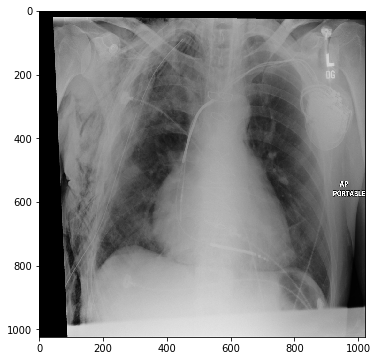

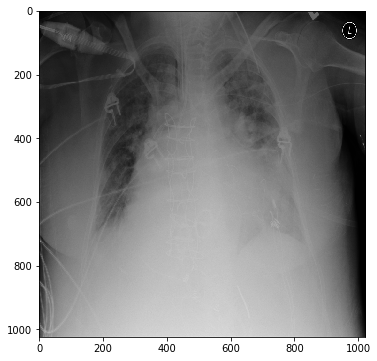

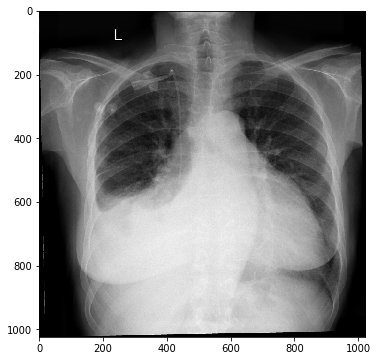

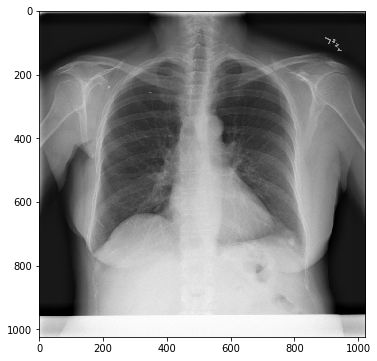

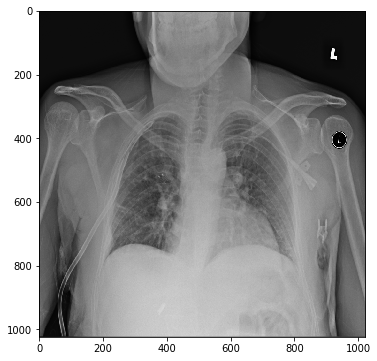

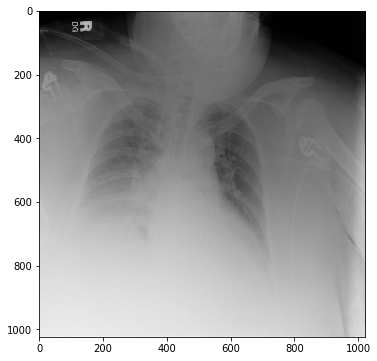

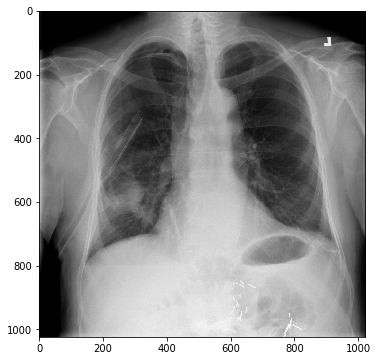

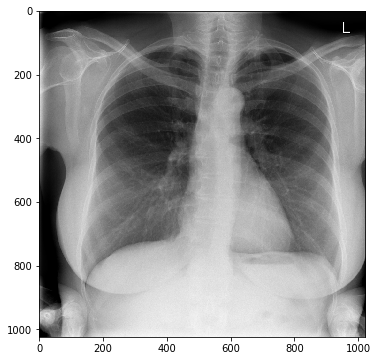

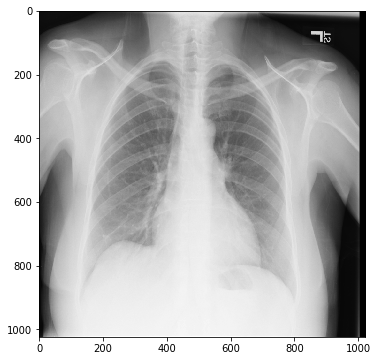

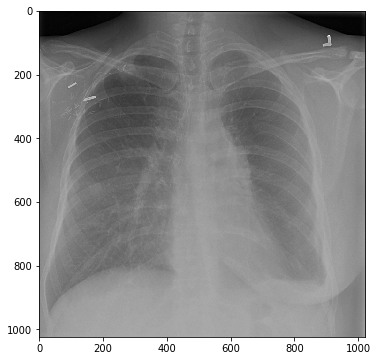

In [295]:
# Sample data
it = iter(test_loader)
for i in range(10):
    # Get a random index value for an index in the batch
    idx = np.random.randint(0, 99, 1)[0]
    # Use the random index to get an image, label in the batch
    image, label = [x[idx] for x in next(it)]
    plt.figure(num=None, figsize=(8, 6))
    plt.imshow(image.numpy().reshape(512, 512),  cmap='gray');
    plt.show()

In [382]:
# Train with the layers frozen for 1 epoch
chx_model.train(1, train_loader)

RuntimeError: exp_vml_cpu not implemented for 'Long'